In [1]:
# Login and database access
import psycopg2
import psycopg2.extras
import getpass

# Plotting
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import ipywidgets as widgets

# Math
import numpy as np
import pandas as pd
import copy

# Custom
from decam_utils import *

The purpose of this notebook is to search through the COSMOS field objects to identify candidates that are likely supernovae. This is done by selecting every candidate that has at least 10 detections over at least 1 month, with a change of at least 1.4 mag, and that doesn't increase in brightness more than once (numbers adjustable below)

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

db = psycopg2.connect( f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'" )
db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


### Adjustable parameters

In [3]:
# Minimum timespan between first and last detections in g, r, and i
tspang, tspanr, tspani = 15, 15, 15
maxtspan = 1000
# tspang, tspanr, tspani = 10, 10, 10 # Use for ELIAS
# Minimum number of detections in g, r, and i
numdetg, numdetr, numdeti = 10, 10, 10
# Minimum magnitude change in g, r, and i
minmagg, minmagr, minmagi = 0.6, 0.6, 0.6
# The number of standard deviations tolerated to stretch the definition of increasing/decreasing
# (0.3 seems to be the sweet spot, but a little higher works too)
errmult = 0.3
# Maximum average error a candidate's detections can have before they are eliminated from consideration
rmaxerr, gmaxerr, imaxerr = 0.2, 0.2, 0.2


field = "COSMOS"
# field = "ELIAS"

In [68]:
if field == "COSMOS":
    query = ( 'SELECT o.id, o.candidate_id, e.mjd, o.mag, e.filter, o.magerr, e.filename FROM objects o '
             'JOIN subtractions s ON o.subtraction_id=s.id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
             'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
             'AND e.mjd < 59377 ' 
             'AND rbs.rb > 0.6 '
             'ORDER BY o.candidate_id '
             'LIMIT 10000000' )
elif field == "ELIAS":
    query = ( 'SELECT o.id, o.candidate_id, e.mjd, o.mag, e.filter, o.magerr, e.filename FROM objects o '
             'JOIN subtractions s ON o.subtraction_id=s.id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
             'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,2) '
             'AND e.mjd < 59377 ' 
             'AND rbs.rb > 0.6 '
             'ORDER BY o.candidate_id '
             'LIMIT 10000000' )

cursor.execute( query )

SNquery = np.array( cursor.fetchall() ).transpose()

In [69]:
SNquery = rm_dupes(SNquery,0)

2068 duplicates removed


### Nonstandard exposure time filter

In [71]:
# Reads in lookup table with filenames and exposure times
lutable = np.loadtxt( "fnm_exptime.txt", dtype=object ).transpose()
fnmtable, exptable = lutable[0], lutable[1].astype(float)

fnms = SNquery[6]
fnms = [fnms[i][:21] for i in range( len( fnms ) )] # truncate filenames to match lookup table format

# Attach an exposure time to every object we pulled in the query
exptime = np.array( [exptable[ np.where( fnms[i] == fnmtable )[0]][0] for i in range( len( fnms ) )], dtype=float )

In [72]:
# Eliminate objects from non-standard images
gcands = np.unique(SNquery[1][SNquery[4] == "g"])
rcands = np.unique(SNquery[1][SNquery[4] == "r"])
icands = np.unique(SNquery[1][SNquery[4] == "i"])
print(len(gcands), len(rcands), len(icands))
del gcands, rcands, icands
gmsk = np.where( ( SNquery[4] == "g" ) & ( exptime > 50 ) )[0]
rmsk = np.where( ( SNquery[4] == "r" ) & ( exptime > 20 ) )[0]
imsk = np.where( ( SNquery[4] == "i" ) & ( exptime > 20 ) )[0]
grmsk = np.append( rmsk, gmsk )
grimsk = np.append( grmsk, imsk )

24378 34674 30778


In [73]:
len(gmsk), len(rmsk), len(imsk)

(55453, 61738, 41766)

### g filter:

In [74]:
# Mask to make sure we stay in the r band detections
gmsk = np.where( SNquery[4] == "g" )[0]
gmsk = [i for i in grimsk if i in gmsk]

In [75]:
# Separating out various query results and applying the r mask 
candsg, objs, magsg, magerrsg = SNquery[1][gmsk], SNquery[0].astype(float)[gmsk], SNquery[3][gmsk], SNquery[5][gmsk]
# Create an array of the dates rounded to the nearest MJD
odatesg = np.round( SNquery[2].astype(float) )[gmsk]
# create an array of unique night (rounded to nearest MJD)
datesg = np.unique( odatesg )

# Create an array of unique candidates
ucandsg, ucandctsg = np.unique( candsg, return_counts=True )

cut0candsg = ucandsg[np.where(ucandctsg > numdetg)[0]]
cut0rg = [i for i in ucandsg if i not in cut0candsg]

nummskg = np.isin(candsg, ucandsg, invert=False)
candsg, objs, magsg, magerrsg, odatesg = candsg[nummskg], objs[nummskg], magsg[nummskg], magerrsg[nummskg], odatesg[nummskg]

In [76]:
# Create for each unique candidate an array of the dates it was observed on and store those arrays in a larger array (ucanddatesr)
ucanddatesg = np.array( [odatesg[ np.where( candsg==i )[0] ] for i in cut0candsg] )
# Create for each unique candidate an array of measured magnitudes and store those arrays in a larger array (ucandmagsr)
ucandmagsg = np.array( [magsg[ np.where( candsg==i )[0] ] for i in cut0candsg] )
# Create for each unique candidate an array of measured magnitude error bars and store those arrays in a larger array (ucandmagerrsr)
ucandmagerrsg = np.array( [magerrsg[ np.where( candsg==i )[0] ] for i in cut0candsg] )

/tmp/ipykernel_30694/3431569689.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucanddatesg = np.array( [odatesg[ np.where( candsg==i )[0] ] for i in cut0candsg] )
/tmp/ipykernel_30694/3431569689.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucandmagsg = np.array( [magsg[ np.where( candsg==i )[0] ] for i in cut0candsg] )
/tmp/ipykernel_30694/3431569689.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If 

In [77]:
# Convert those arrays (previously strings) to floats
ucandmagsg = np.array( [i.astype(float) for i in ucandmagsg] )
ucandmagerrsg = np.array( [i.astype(float) for i in ucandmagerrsg] )
ucanddatesg = np.array( [i.astype(float) for i in ucanddatesg] )

/tmp/ipykernel_30694/220325912.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucandmagsg = np.array( [i.astype(float) for i in ucandmagsg] )
/tmp/ipykernel_30694/220325912.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucandmagerrsg = np.array( [i.astype(float) for i in ucandmagerrsg] )
/tmp/ipykernel_30694/220325912.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must speci

In [78]:
# Calculate how many days passed between the first and last detection 
ucandrangeg = np.array( [np.max(i) - np.min(i) for i in ucanddatesg] )

In [79]:
# Make timespan cuts
cut1g = np.where( (ucandrangeg > tspang) & (ucandrangeg < maxtspan) )[0] # eliminate candidates whose detections dont span at least tspanr days

cut1candsg   =  cut0candsg[cut1g]
cut1datesg   =  ucanddatesg[cut1g]
cut1magsg    =  ucandmagsg[cut1g]
cut1magerrsg =  ucandmagerrsg[cut1g]

# Every candidate removed by this cut
cut1rg = [i for i in cut0candsg if i not in cut1candsg]

# Create another cut for the minimum amplitude in mag
cut1magrangeg = np.array( [np.max(i) - np.min(i) for i in cut1magsg] )
cut2g = np.where( cut1magrangeg > minmagg )[0]

cut2candsg   =  cut1candsg[cut2g]
cut2datesg   =  cut1datesg[cut2g]
cut2magsg    =  cut1magsg[cut2g]
cut2magerrsg =  cut1magerrsg[cut2g]

# Every candidate removed by this cut
cut2rg = [i for i in cut1candsg if i not in cut2candsg]


# Create another cut for where the magerror is too high
cut2magerrrangeg = np.array( [np.mean(i) for i in cut2magerrsg] )
cut3g = np.where( cut2magerrrangeg < gmaxerr )[0]

# And apply that cut as well
cut3candsg   =  cut2candsg[cut3g]
cut3datesg   =  cut2datesg[cut3g]
cut3magsg    =  cut2magsg[cut3g]
cut3magerrsg =  cut2magerrsg[cut3g]

# Every candidate removed by this cut
cut3rg = [i for i in cut2candsg if i not in cut3candsg]

In [80]:
# Create new arrays with the same dimensions as the cutdatesr, cutmagsr, and cutmagerrs arrays (those share dimensions)

cut3datesg2 = copy.deepcopy( cut3datesg )
nightg = copy.deepcopy( cut3datesg )
nightgmag = copy.deepcopy( cut3datesg )
nightgmagerr = copy.deepcopy( cut3datesg )

for i in range( len( cut3datesg2 ) ):
    # make an array of every night the candidate in question (candidate "i") was detected
    unightg = np.unique( cut3datesg2[i] )
    for j in range( len( unightg ) ):
        # For each of those nights, make a mask that selects every observation that night
        msk = np.where( cut3datesg2[i] == unightg[j] )[0]
        # Populate the arrays we created earlier in the cell with appropriate values for the night of the observation,
        # the average magnitude measured that night, and the error (propogated from individual errors) in that average measurement
        # NOTE: there will be meaningless numbers at the end of each (nightr/nightrmag/nightrmagerr)[i] array, left over from
        # when we created them by copying another array. It isn't elegant but it is accounted for later
        nightg[i][j] = unightg[j]
        nightgmag[i][j] = np.median( cut3magsg[i][msk] )
        nightgmagerr[i][j] = np.sqrt( np.sum( cut3magerrsg[i][msk]**2 ) )

In [81]:
# Create an array of dataframes. Each dataframe represents one candidate, and each contains "Night", "Mag", and "Magerr" columns, 
# with each row representing one night
dfg = [pd.DataFrame(np.array(
    [nightg[i][:len( np.unique( nightg[i] ) )], 
     nightgmag[i][:len( np.unique( nightg[i] ) )], 
     nightgmagerr[i][:len( np.unique( nightg[i] ) )]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range( len( cut3candsg ) )]

In [82]:
# This cell creates a mask to eliminate variable stars from the search:
varstarmskg = np.ones( len( dfg ), dtype=bool )
for i in range( len( dfg ) ):
    num = 0
    h = 0
    # First, make sure that the dataframes in the dfr array are each in chronological order
    dfg[i] = dfg[i].sort_values( by="Night" )
    for j in range( len( dfg[i]["Mag"] ) - 1 ):
        h += 1
        if ( num >= 0 ) & ( num < 1 ):
            # On the rise, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfg[i]["Mag"][j] + errmult * dfg[i]["Magerr"][j] > dfg[i]["Mag"][j + 1] - errmult * dfg[i]["Magerr"][j + 1]:
                pass
            else:
                # Once that condition isn't met, 'num' changes, sending us to the descending loop
                num += 1
        if (num >= 1) & (num < 2):
            # On the decline, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfg[i]["Mag"][j] - errmult * dfg[i]["Magerr"][j] < dfg[i]["Mag"][j + 1] + errmult * dfg[i]["Magerr"][j + 1]:
                pass
            else:
                # If this fails, it means that we went up, down, and up again--not a SN, so
                num += 1
#         if num == 2:
#             if dfg[i]["Mag"][j]+dfg[i]["Magerr"][j] > dfg[i]["Mag"][j+1]-errmult*dfg[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
#         if num == 3:
#             if dfg[i]["Mag"][j]-dfg[i]["Magerr"][j] < dfg[i]["Mag"][j+1]+errmult*dfg[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
        if num == 2:# and h<10:
            # We make a note of that in the 'varstarmskg' mask
            varstarmskg[i] = False

In [83]:
# Number of candidates that passed all g cuts
sum(varstarmskg.astype(int))

29

In [84]:
SNg = np.array([cut3candsg[f] for f in np.array(range(len(cut3datesg)))[varstarmskg]]) # Every passed cadidate
cut4rg = [i for i in cut3candsg if i not in SNg]

# cut4candsg = np.array([cut3candsg[f] for f in np.array(range(len(cut3datesg)))[varstarmskg]]) # Every passed cadidate
# cut4rg = [i for i in cut3candsg if i not in cut4candsg]

# RBs = []
# for i in cut4candsg:
#     query = ('SELECT o.rb FROM objects o '
#              'JOIN subtractions s ON s.id=o.subtraction_id '
#              'JOIN exposures e ON e.id = s.exposure_id '
#              'WHERE o.candidate_id = %s '
#              'AND e.filter = %s '
#              'LIMIT 10000 ' )
#     cursor.execute( query, (i,'g',))
#     medRB = np.median( np.array( cursor.fetchall() ).transpose() )
#     RBs.extend( [medRB] )
# RBs = np.array( RBs )
# cut5g = np.where( RBs > 0.6 )[0]

# SNg = cut4candsg[cut5g]
# cut5rg = [i for i in cut4candsg if i not in SNg]

# Plotting only those that passed through the r-band filter
# for f in np.array( range( len( cut3datesg ) ) )[varstarmskg]:
#     g = len( np.unique( cut3datesg[f] ) )
#     plt.errorbar(nightg[f][:g],nightgmag[f][:g], yerr=nightgmagerr[f][:g])
#     plt.title(cut3candsg[f] + " (g)")
#     plt.ylabel("Magnitude")
#     plt.xlabel("MJD")
#     plt.gca().invert_yaxis()
#     plt.show()

In [85]:
# Number of candidates each step eliminated
[len(cut0rg),len(cut1rg),len(cut2rg),len(cut3rg),len(cut4rg)]

[22831, 8, 206, 1, 572]

### r filter:

In [86]:
# Mask to make sure we stay in the r band detections
rmsk = np.where( SNquery[4] == "r" )[0]
rmsk = [i for i in grimsk if i in rmsk]

In [87]:
# Separating out various query results and applying the r mask 
candsr, objs, magsr, magerrsr = SNquery[1][rmsk], SNquery[0].astype(float)[rmsk], SNquery[3][rmsk], SNquery[5][rmsk]
# Create an array of the dates rounded to the nearest MJD
odatesr = np.round( SNquery[2].astype(float) )[rmsk]
# create an array of unique night (rounded to nearest MJD)
datesr = np.unique( odatesr )

# Create an array of unique candidates
ucandsr, ucandctsr = np.unique( candsr, return_counts=True )

cut0candsr = ucandsr[np.where(ucandctsr > numdetr)[0]]
cut0rr = [i for i in ucandsr if i not in cut0candsr]

nummskr = np.isin(candsr, ucandsr, invert=False)
candsr, objs, magsr, magerrsr, odatesr = candsr[nummskr], objs[nummskr], magsr[nummskr], magerrsr[nummskr], odatesr[nummskr]

In [88]:
# Create for each unique candidate an array of the dates it was observed on and store those arrays in a larger array (ucanddatesr)
ucanddatesr = np.array( [odatesr[ np.where( candsr==i )[0] ] for i in cut0candsr] )
# Create for each unique candidate an array of measured magnitudes and store those arrays in a larger array (ucandmagsr)
ucandmagsr = np.array( [magsr[ np.where( candsr==i )[0] ] for i in cut0candsr] )
# Create for each unique candidate an array of measured magnitude error bars and store those arrays in a larger array (ucandmagerrsr)
ucandmagerrsr = np.array( [magerrsr[ np.where( candsr==i )[0] ] for i in cut0candsr] )

/tmp/ipykernel_30694/2696614266.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucanddatesr = np.array( [odatesr[ np.where( candsr==i )[0] ] for i in cut0candsr] )
/tmp/ipykernel_30694/2696614266.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucandmagsr = np.array( [magsr[ np.where( candsr==i )[0] ] for i in cut0candsr] )
/tmp/ipykernel_30694/2696614266.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If 

In [89]:
# Convert those arrays (previously strings) to floats
ucandmagsr = np.array( [i.astype(float) for i in ucandmagsr] )
ucandmagerrsr = np.array( [i.astype(float) for i in ucandmagerrsr] )
ucanddatesr = np.array( [i.astype(float) for i in ucanddatesr] )

/tmp/ipykernel_30694/2364201928.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucandmagsr = np.array( [i.astype(float) for i in ucandmagsr] )
/tmp/ipykernel_30694/2364201928.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucandmagerrsr = np.array( [i.astype(float) for i in ucandmagerrsr] )
/tmp/ipykernel_30694/2364201928.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must sp

In [90]:
# Calculate how many days passed between the first and last detection 
ucandranger = np.array( [np.max(i) - np.min(i) for i in ucanddatesr] )

In [91]:
# Make timespan cuts
cut1r = np.where( ( ucandranger > tspanr ) & ( ucandranger < maxtspan ) )[0] # eliminate candidates whose detections dont span at least tspanr days

cut1candsr   =  cut0candsr[cut1r]
cut1datesr   =  ucanddatesr[cut1r]
cut1magsr    =  ucandmagsr[cut1r]
cut1magerrsr =  ucandmagerrsr[cut1r]

# Every candidate removed by this cut
cut1rr = [i for i in cut0candsr if i not in cut1candsr]


# Create another cut for the minimum amplitude in mag
cut1magranger = np.array( [np.max(i) - np.min(i) for i in cut1magsr] )
cut2r = np.where( cut1magranger > minmagr )[0]

cut2candsr   =  cut1candsr[cut2r]
cut2datesr   =  cut1datesr[cut2r]
cut2magsr    =  cut1magsr[cut2r]
cut2magerrsr =  cut1magerrsr[cut2r]

# Every candidate removed by this cut
cut2rr = [i for i in cut1candsr if i not in cut2candsr]


# Create another cut for where the magerror is too high
cut2magerrranger = np.array( [np.mean(i) for i in cut2magerrsr] )
cut3r = np.where( cut2magerrranger < rmaxerr )[0]

# And apply that cut as well
cut3candsr   =  cut2candsr[cut3r]
cut3datesr   =  cut2datesr[cut3r]
cut3magsr    =  cut2magsr[cut3r]
cut3magerrsr =  cut2magerrsr[cut3r]

# Every candidate removed by this cut
cut3rr = [i for i in cut2candsr if i not in cut3candsr]

In [92]:
# Create new arrays with the same dimensions as the cutdatesr, cutmagsr, and cutmagerrs arrays (those share dimensions)

cut3datesr2 = copy.deepcopy( cut3datesr )
nightr = copy.deepcopy( cut3datesr )
nightrmag = copy.deepcopy( cut3datesr )
nightrmagerr = copy.deepcopy( cut3datesr )

for i in range( len( cut3datesr2 ) ):
    # make an array of every night the candidate in question (candidate "i") was detected
    unightr = np.unique( cut3datesr2[i] )
    for j in range( len( unightr ) ):
        # For each of those nights, make a mask that selects every observation that night
        msk = np.where( cut3datesr2[i] == unightr[j] )[0]
        # Populate the arrays we created earlier in the cell with appropriate values for the night of the observation,
        # the average magnitude measured that night, and the error (propogated from individual errors) in that average measurement
        # NOTE: there will be meaningless numbers at the end of each (nightr/nightrmag/nightrmagerr)[i] array, left over from
        # when we created them by copying another array. It isn't elegant but it is accounted for later
        nightr[i][j] = unightr[j]
        nightrmag[i][j] = np.median( cut3magsr[i][msk] )
        nightrmagerr[i][j] = np.sqrt( np.sum( cut3magerrsr[i][msk]**2 ) )

In [93]:
# Create an array of dataframes. Each dataframe represents one candidate, and each contains "Night", "Mag", and "Magerr" columns, 
# with each row representing one night
dfr = [pd.DataFrame(np.array(
    [nightr[i][:len( np.unique( nightr[i] ) )], 
     nightrmag[i][:len( np.unique( nightr[i] ) )], 
     nightrmagerr[i][:len( np.unique( nightr[i] ) )]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range( len( cut3candsr ) )]

In [94]:
# This cell creates a mask to eliminate variable stars from the search:
varstarmskr = np.ones( len( dfr ), dtype=bool )
for i in range( len( dfr ) ):
    num = 0
    h = 0
    # First, make sure that the dataframes in the dfr array are each in chronological order
    dfr[i] = dfr[i].sort_values( by="Night" )
    for j in range( len( dfr[i]["Mag"] ) - 1 ):
        h += 1
        if ( num >= 0 ) & ( num < 1 ):
            # On the rise, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfr[i]["Mag"][j] + errmult * dfr[i]["Magerr"][j] > dfr[i]["Mag"][j + 1] - errmult * dfr[i]["Magerr"][j + 1]:
                pass
            else:
                # Once that condition isn't met, 'num' changes, sending us to the descending loop
                num += 1
        if (num >= 1) & (num < 2):
            # On the decline, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfr[i]["Mag"][j] - errmult * dfr[i]["Magerr"][j] < dfr[i]["Mag"][j + 1] + errmult * dfr[i]["Magerr"][j + 1]:
                pass
            else:
                # If this fails, it means that we went up, down, and up again--not a SN, so
                num += 1
#         if num == 2:
#             if dfr[i]["Mag"][j]+dfr[i]["Magerr"][j] > dfr[i]["Mag"][j+1]-errmult*dfr[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
#         if num == 3:
#             if dfr[i]["Mag"][j]-dfr[i]["Magerr"][j] < dfr[i]["Mag"][j+1]+errmult*dfr[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
        if num == 2:# and h<10:
            # We make a note of that in the 'varstarmskr' mask
            varstarmskr[i] = False

In [95]:
# Number of candidates that passed all r cuts
sum(varstarmskr.astype(int))

27

In [96]:
SNr = np.array([cut3candsr[f] for f in np.array(range(len(cut3datesr)))[varstarmskr]]) # Every passed cadidate
cut4rr = [i for i in cut3candsr if i not in SNr]

# cut4candsr = np.array([cut3candsr[f] for f in np.array(range(len(cut3datesr)))[varstarmskr]]) # Every passed candidate
# cut4rr = [i for i in cut3candsr if i not in cut4candsr]

# RBs = []
# for i in cut4candsr:
#     query = ('SELECT o.rb FROM objects o '
#              'JOIN subtractions s ON s.id=o.subtraction_id '
#              'JOIN exposures e ON e.id = s.exposure_id '
#              'WHERE o.candidate_id = %s '
#              'AND e.filter = %s '
#              'LIMIT 10000 ' )
#     cursor.execute( query, (i,'r',))
#     medRB = np.median( np.array( cursor.fetchall() ).transpose() )
#     RBs.extend( [medRB] )
# RBs = np.array( RBs )
# cut5r = np.where( RBs > 0.6 )[0]

# SNr = cut4candsr[cut5r]
# cut5rr = [i for i in cut4candsr if i not in SNr]

# Plotting only those that passed through the r-band filter
# for f in np.array( range( len( cut3datesr ) ) )[varstarmskr]:
#     g = len( np.unique( cut3datesr[f] ) )
#     plt.errorbar(nightr[f][:g],nightrmag[f][:g], yerr=nightrmagerr[f][:g])
#     plt.title(cut3candsr[f] + " (r)")
#     plt.ylabel("Magnitude")
#     plt.xlabel("MJD")
#     plt.gca().invert_yaxis()
#     plt.show()

In [97]:
# Number of candidates each step eliminated
[len(cut0rr),len(cut1rr),len(cut2rr),len(cut3rr),len(cut4rr)]

[34090, 7, 225, 0, 325]

### i filter:

In [98]:
# Mask to make sure we stay in the r band detections
imsk = np.where( SNquery[4] == "i" )[0]
imsk = [i for i in grimsk if i in imsk]

In [99]:
# Separating out various query results and applying the r mask 
candsi, objs, magsi, magerrsi = SNquery[1][imsk], SNquery[0].astype(float)[imsk], SNquery[3][imsk], SNquery[5][imsk]
# Create an array of the dates rounded to the nearest MJD
odatesi = np.round( SNquery[2].astype(float) )[imsk]
# create an array of unique night (rounded to nearest MJD)
datesi = np.unique( odatesi )

# Create an array of unique candidates
ucandsi, ucandctsi = np.unique( candsi, return_counts=True )

cut0candsi = ucandsi[np.where(ucandctsi > numdetg)[0]]
cut0ri = [i for i in ucandsi if i not in cut0candsi]

nummski = np.isin(candsi, ucandsi, invert=False)
candsi, objs, magsi, magerrsi, odatesi = candsi[nummski], objs[nummski], magsi[nummski], magerrsi[nummski], odatesi[nummski]

In [100]:
# Create for each unique candidate an array of the dates it was observed on and store those arrays in a larger array (ucanddatesr)
ucanddatesi = np.array( [odatesi[ np.where( candsi==i )[0] ] for i in cut0candsi] )
# Create for each unique candidate an array of measured magnitudes and store those arrays in a larger array (ucandmagsr)
ucandmagsi = np.array( [magsi[ np.where( candsi==i )[0] ] for i in cut0candsi] )
# Create for each unique candidate an array of measured magnitude error bars and store those arrays in a larger array (ucandmagerrsr)
ucandmagerrsi = np.array( [magerrsi[ np.where( candsi==i )[0] ] for i in cut0candsi] )

/tmp/ipykernel_30694/431968677.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucanddatesi = np.array( [odatesi[ np.where( candsi==i )[0] ] for i in cut0candsi] )
/tmp/ipykernel_30694/431968677.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucandmagsi = np.array( [magsi[ np.where( candsi==i )[0] ] for i in cut0candsi] )
/tmp/ipykernel_30694/431968677.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

In [101]:
# Convert those arrays (previously strings) to floats
ucandmagsi = np.array( [i.astype(float) for i in ucandmagsi] )
ucandmagerrsi = np.array( [i.astype(float) for i in ucandmagerrsi] )
ucanddatesi = np.array( [i.astype(float) for i in ucanddatesi] )

/tmp/ipykernel_30694/2875944682.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucandmagsi = np.array( [i.astype(float) for i in ucandmagsi] )
/tmp/ipykernel_30694/2875944682.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ucandmagerrsi = np.array( [i.astype(float) for i in ucandmagerrsi] )
/tmp/ipykernel_30694/2875944682.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must sp

In [102]:
# Calculate how many days passed between the first and last detection 
ucandrangei = np.array( [np.max(i) - np.min(i) for i in ucanddatesi] )

In [103]:
# Make timespan cuts
cut1i = np.where( ( ucandrangei > tspang ) & (ucandrangei < maxtspan) )[0] # eliminate candidates whose detections dont span at least tspanr days

cut1candsi   =  cut0candsi[cut1i]
cut1datesi   =  ucanddatesi[cut1i]
cut1magsi    =  ucandmagsi[cut1i]
cut1magerrsi =  ucandmagerrsi[cut1i]

# Every candidate removed by this cut
cut1ri = [i for i in cut0candsi if i not in cut1candsi]

# Create another cut for the minimum amplitude in mag
cut1magrangei = np.array( [np.max(i) - np.min(i) for i in cut1magsi] )
cut2i = np.where( cut1magrangei > minmagi )[0]

cut2candsi   =  cut1candsi[cut2i]
cut2datesi   =  cut1datesi[cut2i]
cut2magsi    =  cut1magsi[cut2i]
cut2magerrsi =  cut1magerrsi[cut2i]

# Every candidate removed by this cut
cut2ri = [i for i in cut1candsi if i not in cut2candsi]


# Create another cut for where the magerror is too high
cut2magerrrangei = np.array( [np.mean(i) for i in cut2magerrsi] )
cut3i = np.where( cut2magerrrangei < imaxerr )[0]

# And apply that cut as well
cut3candsi   =  cut2candsi[cut3i]
cut3datesi   =  cut2datesi[cut3i]
cut3magsi    =  cut2magsi[cut3i]
cut3magerrsi =  cut2magerrsi[cut3i]

# Every candidate removed by this cut
cut3ri = [i for i in cut2candsi if i not in cut3candsi]

In [104]:
# Create new arrays with the same dimensions as the cutdatesr, cutmagsr, and cutmagerrs arrays (those share dimensions)

cut3datesi2 = copy.deepcopy( cut3datesi )
nighti = copy.deepcopy( cut3datesi )
nightimag = copy.deepcopy( cut3datesi )
nightimagerr = copy.deepcopy( cut3datesi )

for i in range( len( cut3datesi2 ) ):
    # make an array of every night the candidate in question (candidate "i") was detected
    unighti = np.unique( cut3datesi2[i] )
    for j in range( len( unighti ) ):
        # For each of those nights, make a mask that selects every observation that night
        msk = np.where( cut3datesi2[i] == unighti[j] )[0]
        # Populate the arrays we created earlier in the cell with appropriate values for the night of the observation,
        # the average magnitude measured that night, and the error (propogated from individual errors) in that average measurement
        # NOTE: there will be meaningless numbers at the end of each (nightr/nightrmag/nightrmagerr)[i] array, left over from
        # when we created them by copying another array. It isn't elegant but it is accounted for later
        nighti[i][j] = unighti[j]
        nightimag[i][j] = np.median( cut3magsi[i][msk] )
        nightimagerr[i][j] = np.sqrt( np.sum( cut3magerrsi[i][msk]**2 ) )

In [105]:
# Create an array of dataframes. Each dataframe represents one candidate, and each contains "Night", "Mag", and "Magerr" columns, 
# with each row representing one night
dfi = [pd.DataFrame(np.array(
    [nighti[i][:len( np.unique( nighti[i] ) )], 
     nightimag[i][:len( np.unique( nighti[i] ) )], 
     nightimagerr[i][:len( np.unique( nighti[i] ) )]]).transpose(),
    columns=["Night",
            "Mag",
            "Magerr"])
 for i in range( len( cut3candsi ) )]

In [106]:
# This cell creates a mask to eliminate variable stars from the search:
varstarmski = np.ones( len( dfi ), dtype=bool )
for i in range( len( dfi ) ):
    num = 0
    h = 0
    # First, make sure that the dataframes in the dfr array are each in chronological order
    dfi[i] = dfi[i].sort_values( by="Night" )
    for j in range( len( dfi[i]["Mag"] ) - 1 ):
        h += 1
        if ( num >= 0 ) & ( num < 1 ):
            # On the rise, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfi[i]["Mag"][j] + errmult * dfi[i]["Magerr"][j] > dfi[i]["Mag"][j + 1] - errmult * dfi[i]["Magerr"][j + 1]:
                pass
            else:
                # Once that condition isn't met, 'num' changes, sending us to the descending loop
                num += 1
        if (num >= 1) & (num < 2):
            # On the decline, the "current" data point must be lower than the "next" data point (error bars included to give maximum leeway)
            if dfi[i]["Mag"][j] - errmult * dfi[i]["Magerr"][j] < dfi[i]["Mag"][j + 1] + errmult * dfi[i]["Magerr"][j + 1]:
                pass
            else:
                # If this fails, it means that we went up, down, and up again--not a SN, so
                num += 1
#         if num == 2:
#             if dfi[i]["Mag"][j]+dfi[i]["Magerr"][j] > dfi[i]["Mag"][j+1]-errmult*dfi[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
#         if num == 3:
#             if dfi[i]["Mag"][j]-dfi[i]["Magerr"][j] < dfi[i]["Mag"][j+1]+errmult*dfi[i]["Magerr"][j+1]:
#                 pass
#             else:
#                 num+=1
        if num == 2:# and h<10:
            # We make a note of that in the 'varstarmski' mask
            varstarmski[i] = False

In [107]:
# Number of candidates that passed all i cuts
sum(varstarmski.astype(int))

19

In [108]:
SNi = np.array([cut3candsi[f] for f in np.array(range(len(cut3datesi)))[varstarmski]]) # Every passed cadidate
cut4ri = [i for i in cut3candsi if i not in SNi]

# cut4candsi = np.array([cut3candsi[f] for f in np.array(range(len(cut3datesi)))[varstarmski]]) # Every passed candidate
# cut4ri = [i for i in cut3candsi if i not in cut4candsi]

# RBs = []
# for i in cut4candsi:
#     query = ('SELECT o.rb FROM objects o '
#              'JOIN subtractions s ON s.id=o.subtraction_id '
#              'JOIN exposures e ON e.id = s.exposure_id '
#              'WHERE o.candidate_id = %s '
#              'AND e.filter = %s '
#              'LIMIT 10000 ' )
#     cursor.execute( query, (i,'i',))
#     medRB = np.median( np.array( cursor.fetchall() ).transpose() )
#     RBs.extend( [medRB] )
# RBs = np.array( RBs )
# cut5i = np.where( RBs > 0.6 )[0]

# SNi = cut4candsi[cut5i]
# cut5ri = [i for i in cut4candsi if i not in SNi]


# Plotting only those that passed through the r-band filter
# for f in np.array( range( len( cut3datesi ) ) )[varstarmski]:
#     g = len( np.unique( cut3datesi[f] ) )
#     plt.errorbar(nighti[f][:g],nightimag[f][:g], yerr=nightimagerr[f][:g])
#     plt.title(cut3candsi[f] + " (g)")
#     plt.ylabel("Magnitude")
#     plt.xlabel("MJD")
#     plt.gca().invert_yaxis()
#     plt.show()

In [109]:
# Number of candidates in each step of the process for the paper

print("g")
print([len(cut0rg),len(cut1rg),len(cut2rg),len(cut3rg),len(cut4rg), len(SNg)])
print(sum([len(cut1rg),len(cut2rg),len(cut3rg),len(cut4rg), len(SNg)]))
print(sum([len(cut2rg),len(cut3rg),len(cut4rg), len(SNg)]))
print(sum([len(cut3rg),len(cut4rg), len(SNg)]))
print(sum([len(cut4rg), len(SNg)]))
print(sum([len(SNg)]))

print("")
print("r")
print([len(cut0rr),len(cut1rr),len(cut2rr),len(cut3rr),len(cut4rr), len(SNr)])
print(sum([len(cut1rr),len(cut2rr),len(cut3rr),len(cut4rr), len(SNr)]))
print(sum([len(cut2rr),len(cut3rr),len(cut4rr), len(SNr)]))
print(sum([len(cut3rr),len(cut4rr), len(SNr)]))
print(sum([len(cut4rr), len(SNr)]))
print(sum([len(SNr)]))

print("")
print("i")
print([len(cut0ri),len(cut1ri),len(cut2ri),len(cut3ri),len(cut4ri), len(SNi)])
print(sum([len(cut1ri),len(cut2ri),len(cut3ri),len(cut4ri), len(SNi)]))
print(sum([len(cut2ri),len(cut3ri),len(cut4ri), len(SNi)]))
print(sum([len(cut3ri),len(cut4ri), len(SNi)]))
print(sum([len(cut4ri), len(SNi)]))
print(sum([len(SNi)]))

g
[22831, 8, 206, 1, 572, 29]
816
808
602
601
29

r
[34090, 7, 225, 0, 325, 27]
584
577
352
352
27

i
[30601, 1, 104, 0, 53, 19]
177
176
72
72
19


### Putting them together

In [110]:
# Create lists of the candidates that passed any test
SNany = np.unique(np.concatenate([SNg,SNr,SNi]).flat)

# Select the ones detected in at least two filters
SNgr = [i for i in SNr if i in SNg]
SNri = [i for i in SNr if i in SNi]
SNgi = [i for i in SNg if i in SNi]
SNgri = np.unique(np.concatenate([SNgr,SNri,SNgi]).flat)

# And those found in all three
SNgold = [i for i in SNgr if i in SNi] # Golden sample
np.unique(np.concatenate((SNr,SNg)))

array(['DC21bcpi', 'DC21bea', 'DC21bkrj', 'DC21bpls', 'DC21chy',
       'DC21cove', 'DC21dhgr', 'DC21dmf', 'DC21dqf', 'DC21dqik',
       'DC21dtwb', 'DC21ebkp', 'DC21efu', 'DC21empc', 'DC21eqq',
       'DC21fber', 'DC21fgxo', 'DC21fkyg', 'DC21gayy', 'DC21ghay',
       'DC21hunj', 'DC21ikah', 'DC21ixp', 'DC21jfcb', 'DC21jgl',
       'DC21kog', 'DC21ktp', 'DC21kxb', 'DC21mtd', 'DC21olj', 'DC21qil',
       'DC21qyq', 'DC21rpw', 'DC21tpq', 'DC21tsm', 'DC21txw', 'DC21ubb',
       'DC21udz', 'DC21url', 'DC21vnd', 'DC21wlm', 'DC21wue', 'DC21zlo'],
      dtype='<U8')

In [111]:
print(len(SNgold), len(SNgri)-len(SNgold), len(SNany) - len(SNgri))

7 9 36


### A closer look at these SNe

Note that while the filter program only sees detections w/ R/B > 0.6, this displays ALL detections

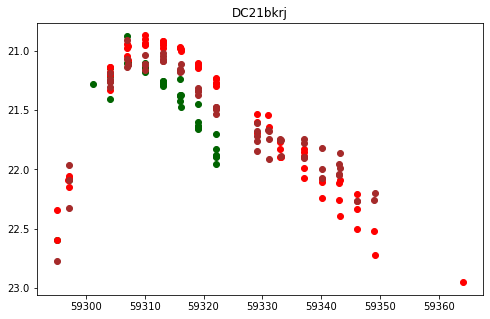

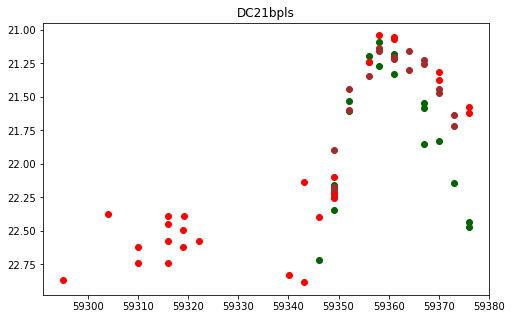

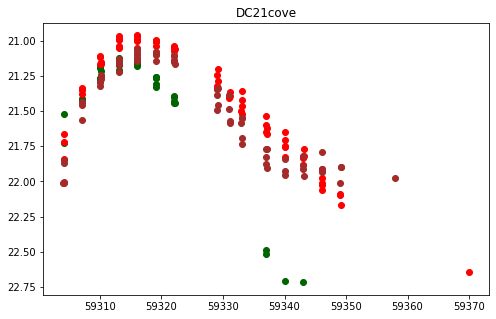

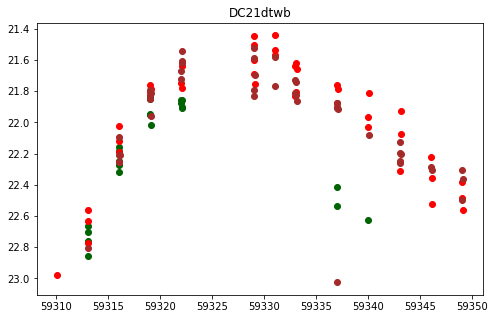

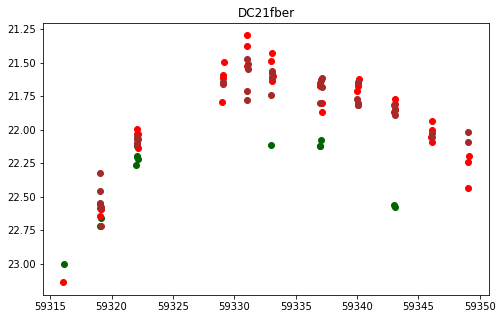

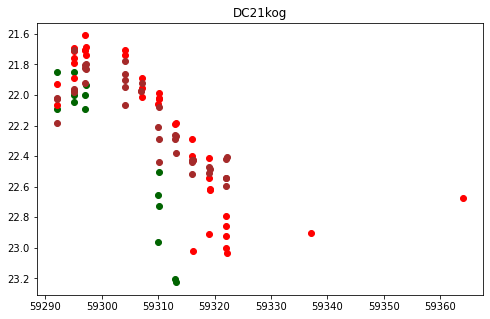

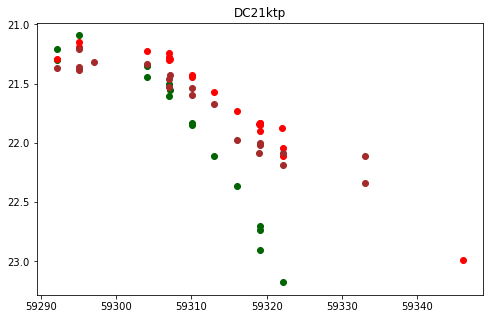

In [112]:
if field == "COSMOS": c = ["darkgreen","red","brown"]
elif field == "ELIAS": c = ["limegreen","darkorange","peru"]

# Plotting lightcurves for each potential SN
for i in SNgold: # Passed in all 3
# for i in [i for i in SNgri if i not in SNgold]: # Passed in only 2
# for i in [i for i in SNany if i not in SNgri]: # Passed in only 1
# for i in [i for i in SNprev if i not in SNany]:
    query = ('SELECT c.id, e.mjd, o.mag, e.filter, rbs.rb FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
             'JOIN exposures e ON e.id=s.exposure_id '
             'WHERE c.id=%s '
             'AND e.mjd < 59377 ' )
    cursor.execute( query, (i, ) )
    array = np.array(cursor.fetchall()).transpose()
    rmsk = np.where(array[3]=='r')[0]
    gmsk = np.where(array[3]=='g')[0]
    imsk = np.where(array[3]=='i')[0]
    
    plt.figure(figsize=(8,5))
#     plt.scatter((array[1][gmsk]).astype(float), (array[2][gmsk]).astype(float), color=c[0], label='g')
#     plt.scatter((array[1][rmsk]).astype(float), (array[2][rmsk]).astype(float), color=c[1], label='r')
#     plt.scatter((array[1][imsk]).astype(float), (array[2][imsk]).astype(float), color=c[2], label='i')
    for i in range(len(gmsk)):
        plt.scatter((array[1][gmsk][i]).astype(float), (array[2][gmsk][i]).astype(float), color=c[0],)# alpha=array[4][gmsk][i])
    for i in range(len(rmsk)):
        plt.scatter((array[1][rmsk][i]).astype(float), (array[2][rmsk][i]).astype(float), color=c[1],)# alpha=array[4][rmsk][i])
    for i in range(len(imsk)):
        plt.scatter((array[1][imsk][i]).astype(float), (array[2][imsk][i]).astype(float), color=c[2],)# alpha=array[4][imsk][i])
    
    plt.title(array[0][0])
    plt.gca().invert_yaxis()
#     plt.legend()
    plt.show()

In [113]:
### This cell pulls out the reference, science, and subtraction images for eack of the SNe the filter detected, for every good detection

# for i in SNgri:
#     query = ( 'SELECT cand.id, e.mjd,e.filename,e.filter,c.sci_jpeg,c.ref_jpeg,c.diff_jpeg FROM cutouts c '
#               'INNER JOIN objects o ON c.object_id=o.id '
#               'INNER JOIN candidates cand ON o.candidate_id=cand.id '
#               'INNER JOIN subtractions s ON o.subtraction_id=s.id '
#               'INNER JOIN exposures e ON s.exposure_id=e.id '
#               'WHERE cand.id=%s '
#               'AND o.rb>0.6 '
#               'ORDER BY e.mjd '
#               'LIMIT 3')
#     cursor.execute( query, ( i, ) )
#     for row in cursor:
#         label = ipywidgets.HTML( f'<b>Candidate</b>{row["id"]}<br><b>{row["filename"]}</b><br><b>Filter:</b> {row["filter"]}' )
#         newimg = ipywidgets.Image( value=bytes(row["sci_jpeg"]), width=102, height=102, format='jpeg' )
#         refimg = ipywidgets.Image( value=bytes(row["ref_jpeg"]), width=102, height=102, format='jpeg' )
#         subimg = ipywidgets.Image( value=bytes(row["diff_jpeg"]), width=102, height=102, format='jpeg' )
#         box = ipywidgets.HBox( [ newimg, refimg, subimg, label ] )
#         display( box )
#     print("")
#     print("")    
#     print("")    
#     print("")

### Convenient coordinate printouts for TNS search https://www.wis-tns.org/

In [114]:
# SNlist = SNgold # 3 passes
# SNlist = SNgri # >=2 passes
SNlist = SNany # >=1 passes
# SNlist = [i for i in SNgri if i not in SNgold] # exactly 2 passes
# SNlist = [i for i in SNany if i not in SNgri] # exactly 1 pass


coordarr = np.empty( len( SNlist ), dtype=object )
for i in range(len(SNlist)):
    query = ('SELECT c.id, c.ra, c.dec FROM candidates c '
            'WHERE c.id=%s ')
    cursor.execute( query, (SNlist[i], ) )
    coordarr[i] = cursor.fetchall()[0]

In [115]:
if field == "COSMOS":
    for i in coordarr:
        print(i[0])
        print(str(i[1]),"+"+str(i[2]))
elif field == "ELIAS":
    for i in coordarr:
        print(i[0])
        print(str(i[1]),str(i[2]))
# List of those that have a match in TNS:
# ['DC21dqik', 'DC21bwbfe',]
# And what their names are in TNS:
# ['AT 2021nfp', 'SN 2021bnv']

DC21bcpi
151.076568049129 +2.67347244082796
DC21bea
151.659764786602 +1.29986028694842
DC21bkrj
150.043978544436 +3.47660190275974
DC21bpls
149.300808259448 +2.094409454409
DC21bwbfe
149.505136477566 +3.80984255394619
DC21chy
150.730413852732 +1.89804521562042
DC21cove
150.205260592532 +3.74323011868333
DC21dhgr
148.96669780135 +1.65455109542668
DC21dmf
149.589157412481 +2.51381494026089
DC21dna
149.909996245912 +2.01191381028806
DC21dqf
149.936831200786 +2.14923495883583
DC21dqik
151.689426712647 +2.00556682067166
DC21dtwb
149.302770735739 +1.77949389263242
DC21ebkp
149.479591655376 +3.63631820861882
DC21edbu
149.795618659146 +1.16311070814633
DC21efu
149.212094223432 +3.57184413711253
DC21empc
150.510223790285 +2.51514379612633
DC21eqq
150.42577440236 +3.40271753256201
DC21eqtm
150.681189136483 +2.81050311645166
DC21fber
149.045078531139 +3.17994689983373
DC21fgxo
149.421779801635 +3.30899768390356
DC21fkyg
149.24421623473 +2.1686044103094
DC21gayy
149.717118082649 +2.47704325443787


### What went wrong with those that passed in only one filter?

In [116]:
# onefiltcands = SNgold # 3 passes
# onefiltcands = SNgri # >=2 passes
onefiltcands = SNany # >=1 passes
# onefiltcands = [i for i in SNgri if i not in SNgold] # exactly 2 passes
# onefiltcands = [i for i in SNany if i not in SNgri] # exactly 1 pass

g = np.empty(len(onefiltcands))
r = np.empty(len(onefiltcands))
i = np.empty(len(onefiltcands))
onefiltdf = pd.DataFrame(np.array([g,r,i]).transpose(), columns=["g","r","i"], index=onefiltcands)

for i in onefiltdf.index:
#     if i in cut5rg:
#         onefiltdf.loc[i,"g"] = "Low med. R/B"
    if i in cut4rg:
        onefiltdf.loc[i,"g"] = "Double-peaked"
    elif i in cut3rg:
        onefiltdf.loc[i,"g"] = "Too noisy"
    elif i in cut2rg:
        onefiltdf.loc[i,"g"] = "Too dim"
    elif i in cut1rg:
        onefiltdf.loc[i,"g"] = "<15 days or >80 days"
    elif i in cut0rg:
        onefiltdf.loc[i,"g"] = "<10 objs"
    elif i in SNg:
        onefiltdf.loc[i,"g"] = "Passed"
    else:
        onefiltdf.loc[i,"g"] = "No data"

#     if i in cut5rr:
#         onefiltdf.loc[i,"r"] = "Low med. R/B"
    if i in cut4rr:
        onefiltdf.loc[i,"r"] = "Double-peaked"
    elif i in cut3rr:
        onefiltdf.loc[i,"r"] = "Too noisy"
    elif i in cut2rr:
        onefiltdf.loc[i,"r"] = "Too dim"
    elif i in cut1rr:
        onefiltdf.loc[i,"r"] = "<15 days or >80 days"
    elif i in cut0rr:
        onefiltdf.loc[i,"r"] = "<10 objs"
    elif i in SNr:
        onefiltdf.loc[i,"r"] = "Passed"
    else:
        onefiltdf.loc[i,"r"] = "No data"
        
#     if i in cut5ri:
#         onefiltdf.loc[i,"i"] = "Low med. R/B"
    if i in cut4ri:
        onefiltdf.loc[i,"i"] = "Double-peaked"
    elif i in cut3ri:
        onefiltdf.loc[i,"i"] = "Too noisy"
    elif i in cut2ri:
        onefiltdf.loc[i,"i"] = "Too dim"
    elif i in cut1ri:
        onefiltdf.loc[i,"i"] = "<15 days or >80 days"
    elif i in cut0ri:
        onefiltdf.loc[i,"i"] = "<10 objs"
    elif i in SNi:
        onefiltdf.loc[i,"i"] = "Passed"
    else:
        onefiltdf.loc[i,"i"] = "No data"
pd.set_option('display.max_rows', 500)
onefiltdf

,g,r,i
DC21bcpi,<10 objs,Passed,Too dim
DC21bea,Passed,Double-peaked,Too dim
DC21bkrj,Passed,Passed,Passed
DC21bpls,Passed,Passed,Passed
DC21bwbfe,No data,No data,Passed
DC21chy,Passed,Double-peaked,No data
DC21cove,Passed,Passed,Passed
DC21dhgr,Passed,Passed,Double-peaked
DC21dmf,Passed,<10 objs,No data
DC21dna,<10 objs,Double-peaked,Passed


#### Reasons for failure along with plots:

This time, only R/B>0.6 (what the filter gets) is plotted

Reasons for failure:
g    <10 objs
r      Passed
i     Too dim
Name: DC21bcpi, dtype: object


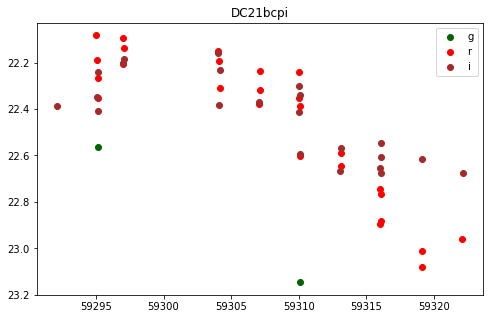

Reasons for failure:
g           Passed
r    Double-peaked
i          Too dim
Name: DC21bea, dtype: object


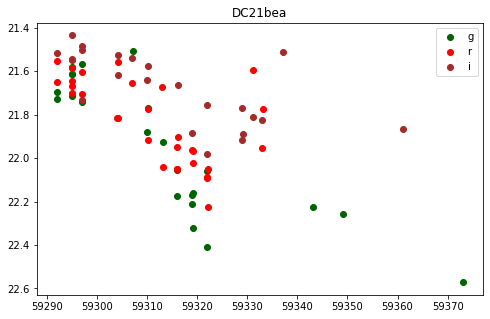

Reasons for failure:
g    Passed
r    Passed
i    Passed
Name: DC21bkrj, dtype: object


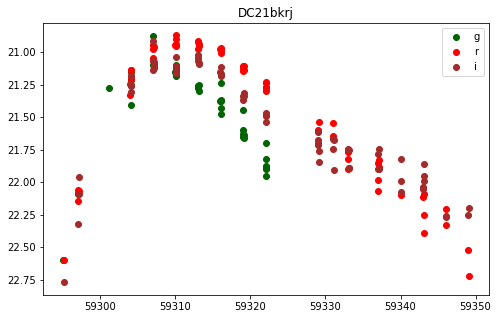

Reasons for failure:
g    Passed
r    Passed
i    Passed
Name: DC21bpls, dtype: object


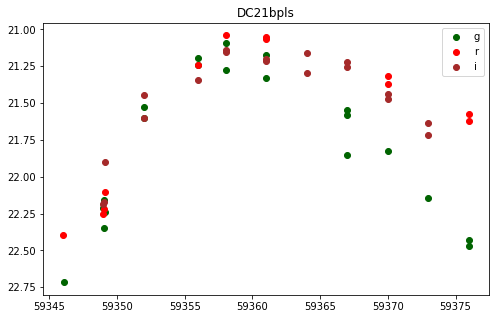

Reasons for failure:
g    No data
r    No data
i     Passed
Name: DC21bwbfe, dtype: object


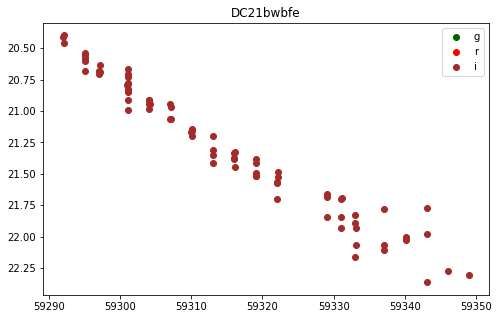

Reasons for failure:
g           Passed
r    Double-peaked
i          No data
Name: DC21chy, dtype: object


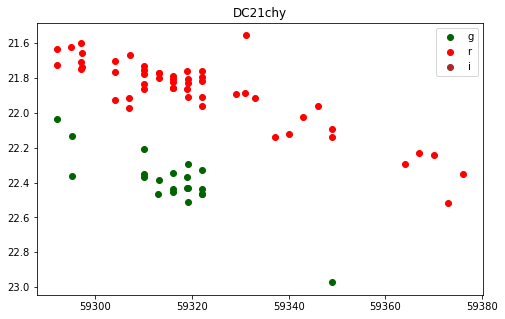

Reasons for failure:
g    Passed
r    Passed
i    Passed
Name: DC21cove, dtype: object


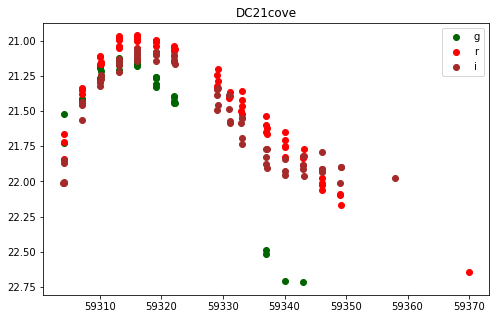

Reasons for failure:
g           Passed
r           Passed
i    Double-peaked
Name: DC21dhgr, dtype: object


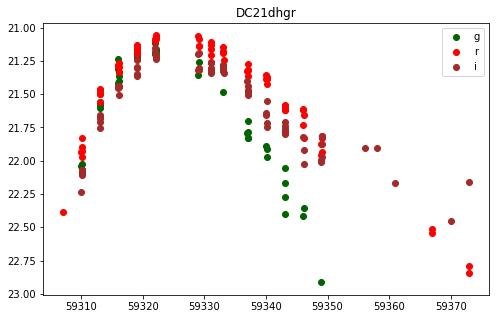

Reasons for failure:
g      Passed
r    <10 objs
i     No data
Name: DC21dmf, dtype: object


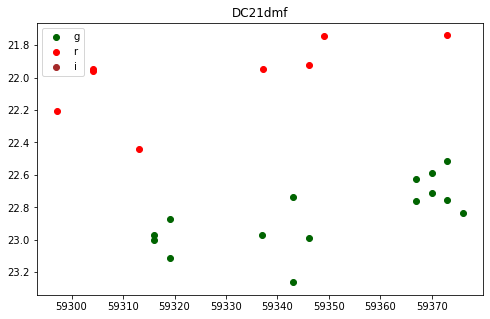

Reasons for failure:
g         <10 objs
r    Double-peaked
i           Passed
Name: DC21dna, dtype: object


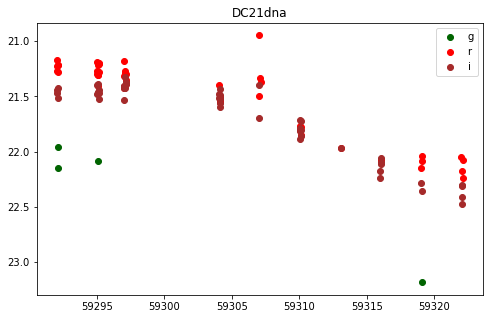

Reasons for failure:
g    Double-peaked
r           Passed
i          Too dim
Name: DC21dqf, dtype: object


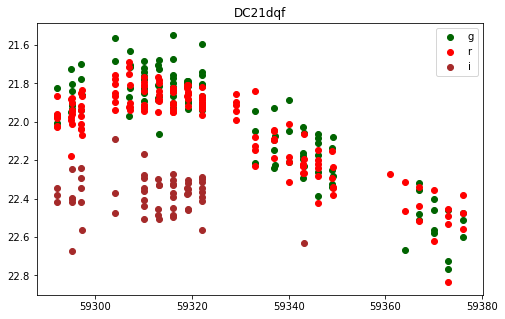

Reasons for failure:
g           Passed
r           Passed
i    Double-peaked
Name: DC21dqik, dtype: object


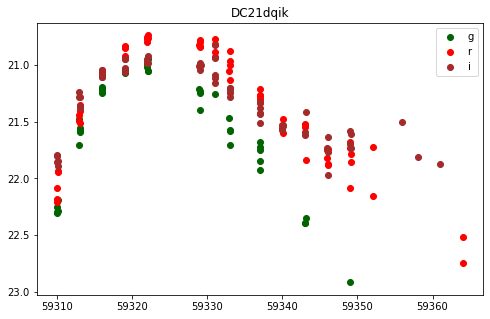

Reasons for failure:
g    Passed
r    Passed
i    Passed
Name: DC21dtwb, dtype: object


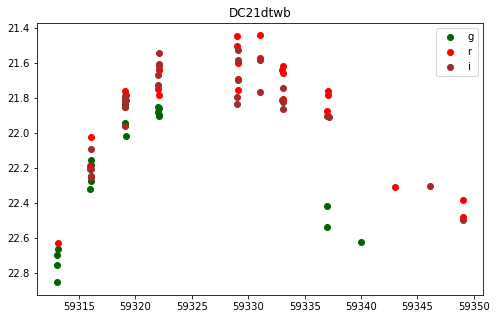

Reasons for failure:
g    <10 objs
r      Passed
i    <10 objs
Name: DC21ebkp, dtype: object


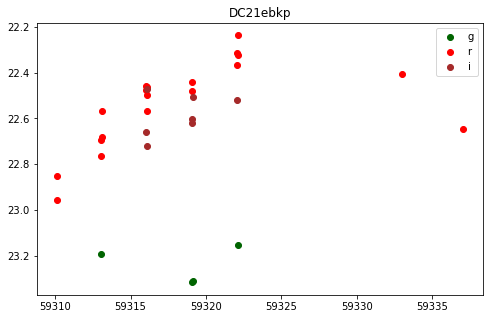

Reasons for failure:
g    Double-peaked
r    Double-peaked
i           Passed
Name: DC21edbu, dtype: object


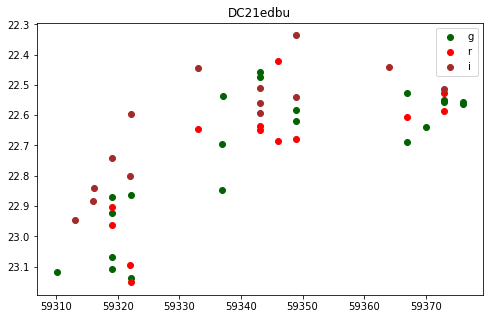

Reasons for failure:
g      Passed
r    <10 objs
i     No data
Name: DC21efu, dtype: object


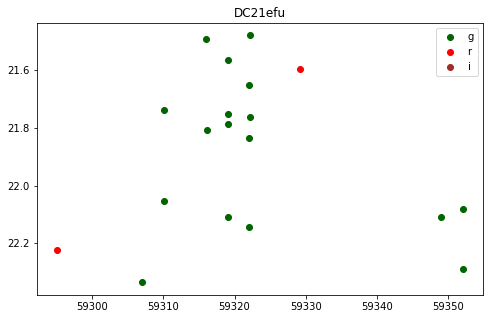

Reasons for failure:
g    No data
r     Passed
i    No data
Name: DC21empc, dtype: object


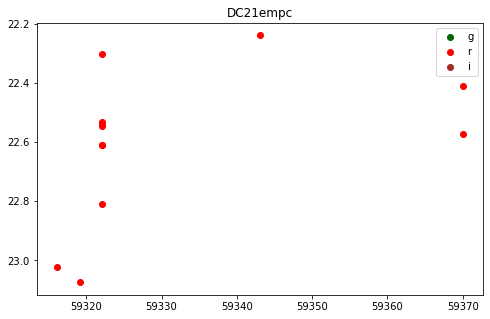

Reasons for failure:
g    <10 objs
r      Passed
i      Passed
Name: DC21eqq, dtype: object


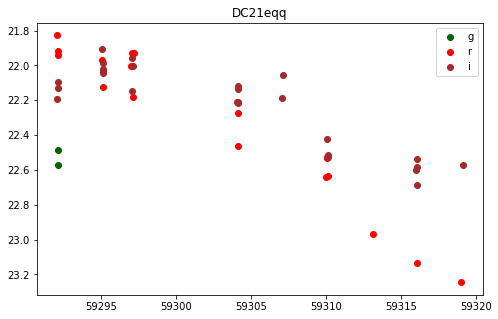

Reasons for failure:
g         <10 objs
r    Double-peaked
i           Passed
Name: DC21eqtm, dtype: object


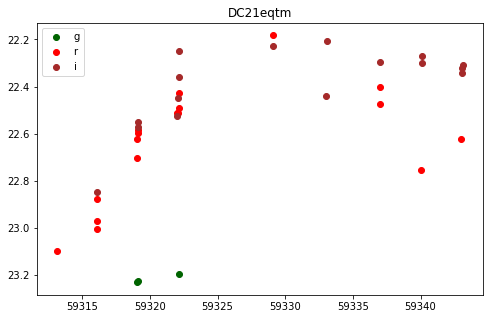

Reasons for failure:
g    Passed
r    Passed
i    Passed
Name: DC21fber, dtype: object


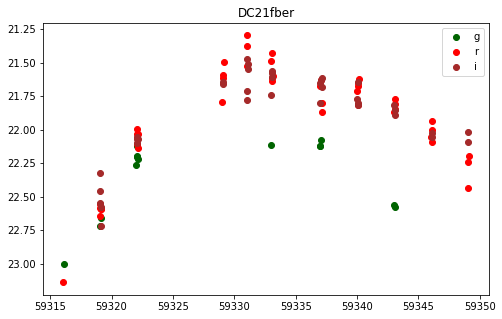

Reasons for failure:
g    <10 objs
r      Passed
i    <10 objs
Name: DC21fgxo, dtype: object


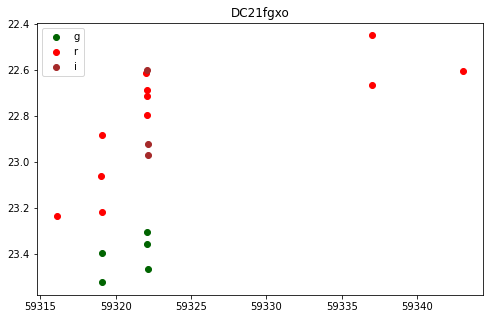

Reasons for failure:
g    No data
r     Passed
i    No data
Name: DC21fkyg, dtype: object


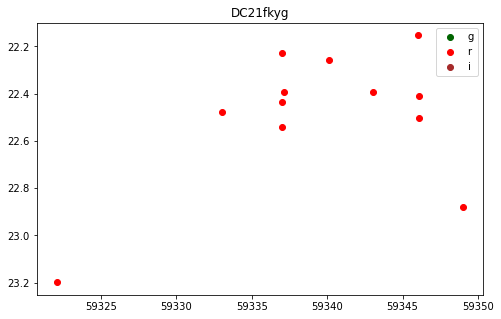

Reasons for failure:
g    No data
r     Passed
i     Passed
Name: DC21gayy, dtype: object


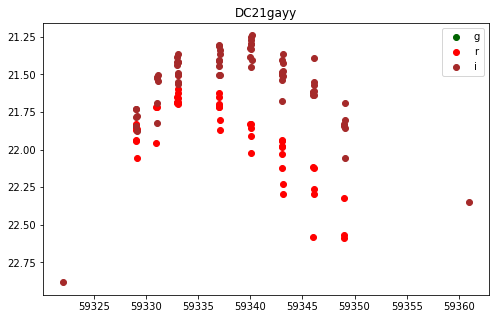

Reasons for failure:
g     Passed
r    No data
i    No data
Name: DC21ghay, dtype: object


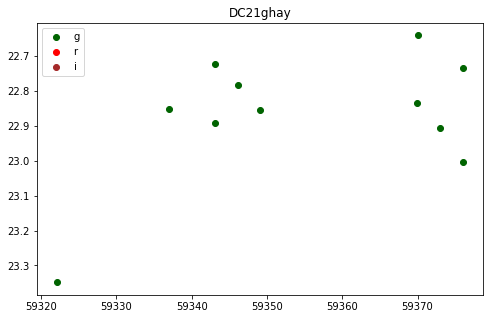

Reasons for failure:
g      Passed
r      Passed
i    <10 objs
Name: DC21hunj, dtype: object


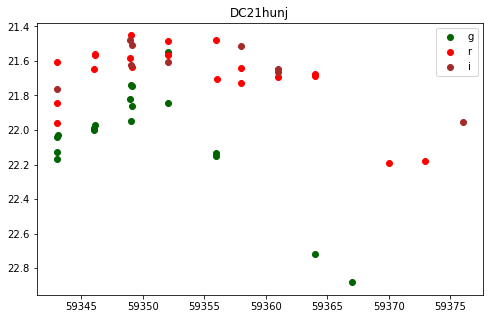

Reasons for failure:
g     No data
r      Passed
i    <10 objs
Name: DC21ikah, dtype: object


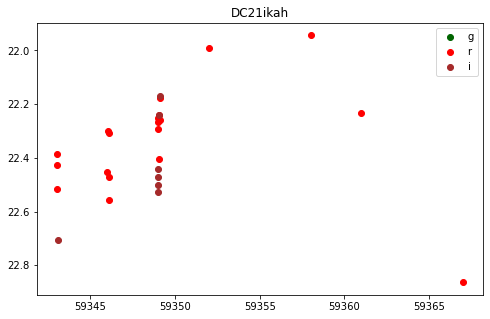

Reasons for failure:
g           Passed
r           Passed
i    Double-peaked
Name: DC21ixp, dtype: object


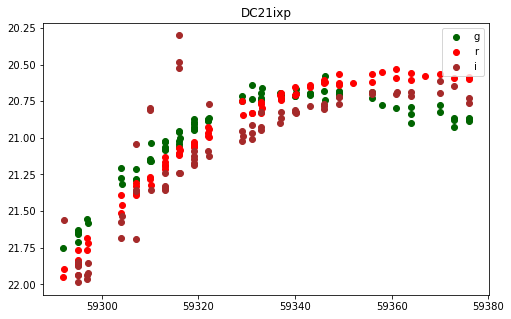

Reasons for failure:
g           Passed
r    Double-peaked
i    Double-peaked
Name: DC21jfcb, dtype: object


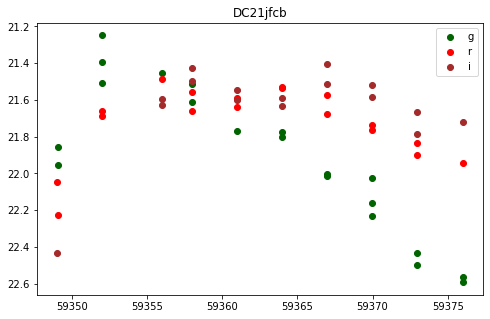

Reasons for failure:
g    Double-peaked
r           Passed
i          No data
Name: DC21jgl, dtype: object


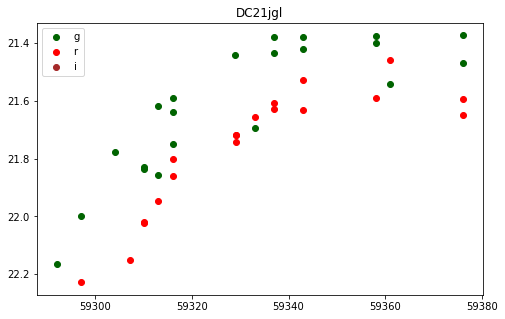

Reasons for failure:
g                <10 objs
r    <15 days or >80 days
i                  Passed
Name: DC21kgy, dtype: object


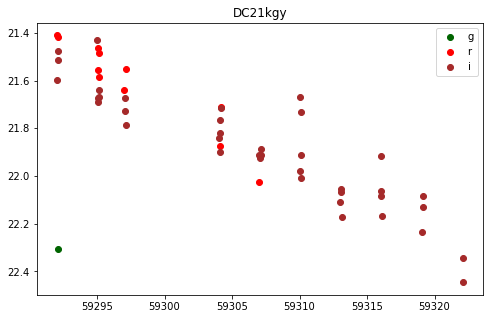

Reasons for failure:
g    Passed
r    Passed
i    Passed
Name: DC21kog, dtype: object


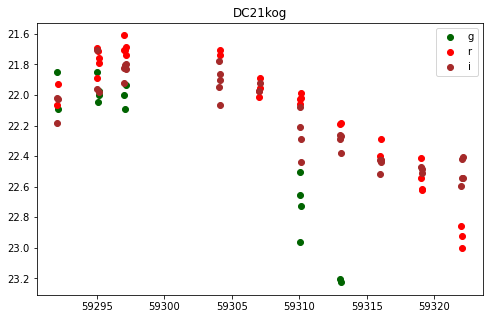

Reasons for failure:
g    Passed
r    Passed
i    Passed
Name: DC21ktp, dtype: object


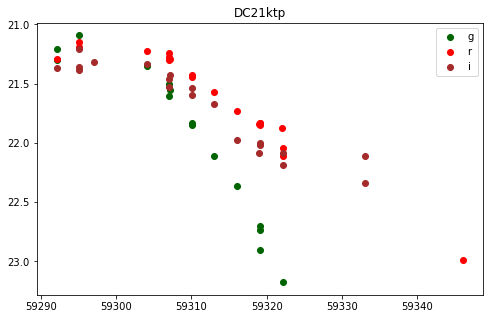

Reasons for failure:
g           Passed
r           Passed
i    Double-peaked
Name: DC21kxb, dtype: object


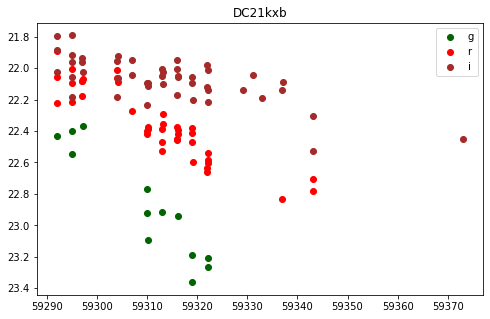

Reasons for failure:
g    Double-peaked
r           Passed
i          No data
Name: DC21mtd, dtype: object


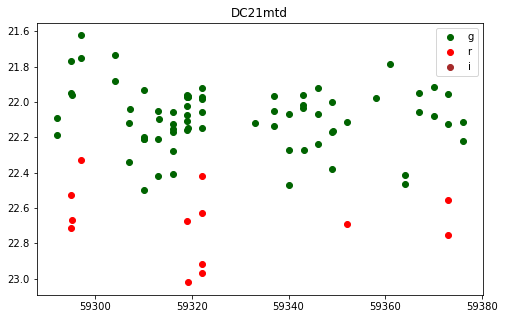

Reasons for failure:
g      Passed
r    <10 objs
i     No data
Name: DC21olj, dtype: object


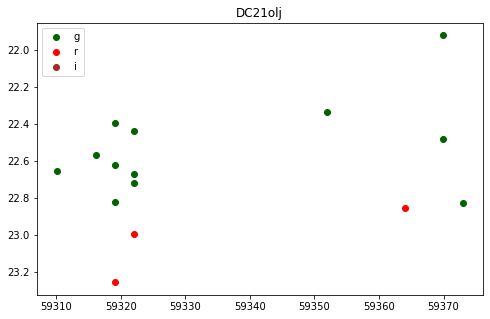

Reasons for failure:
g          Too dim
r    Double-peaked
i           Passed
Name: DC21ovi, dtype: object


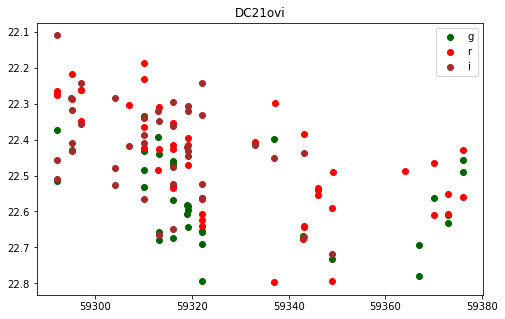

Reasons for failure:
g           Passed
r    Double-peaked
i         <10 objs
Name: DC21qil, dtype: object


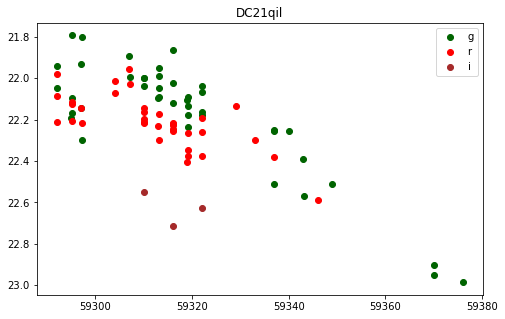

Reasons for failure:
g    <10 objs
r      Passed
i    <10 objs
Name: DC21qyq, dtype: object


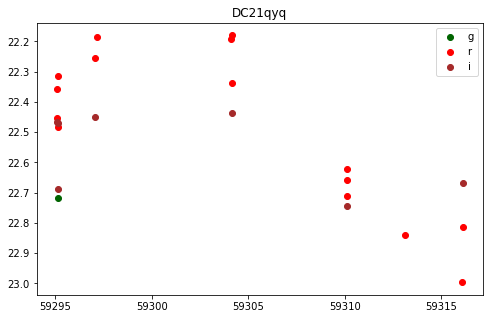

Reasons for failure:
g           Passed
r    Double-peaked
i          No data
Name: DC21rpw, dtype: object


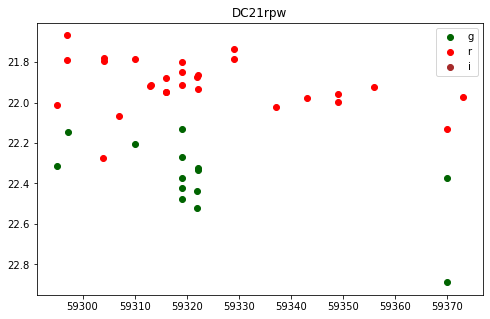

Reasons for failure:
g           Passed
r    Double-peaked
i          Too dim
Name: DC21tpq, dtype: object


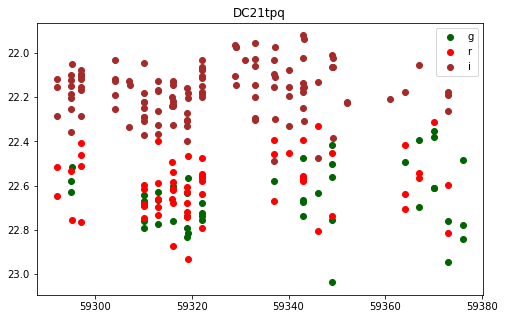

Reasons for failure:
g     Passed
r    Too dim
i    No data
Name: DC21tsm, dtype: object


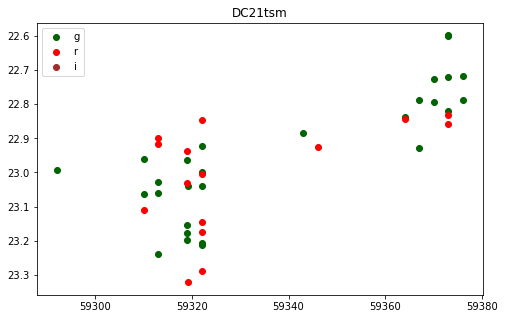

Reasons for failure:
g      Passed
r    <10 objs
i     No data
Name: DC21txw, dtype: object


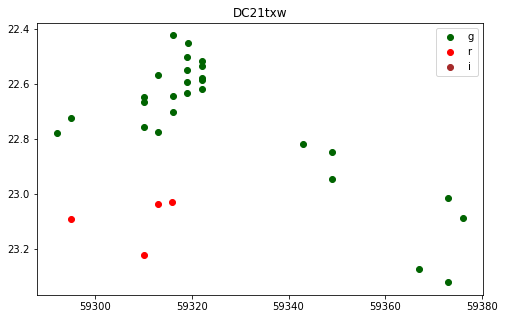

Reasons for failure:
g    Double-peaked
r           Passed
i          Too dim
Name: DC21ubb, dtype: object


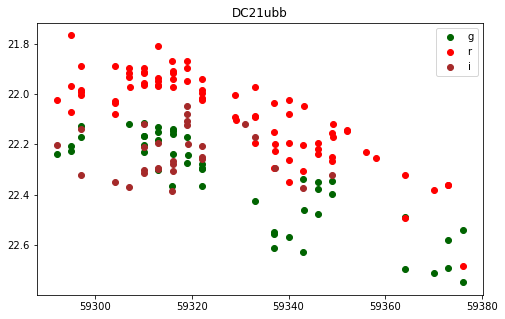

Reasons for failure:
g          Too dim
r    Double-peaked
i           Passed
Name: DC21ubu, dtype: object


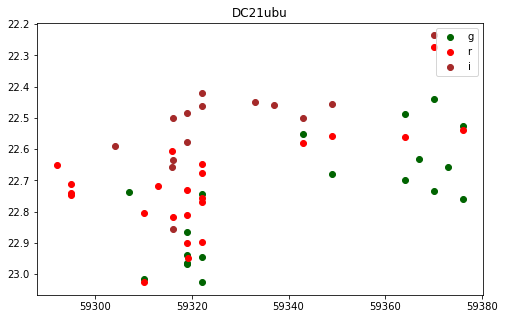

Reasons for failure:
g           Passed
r    Double-peaked
i         <10 objs
Name: DC21udz, dtype: object


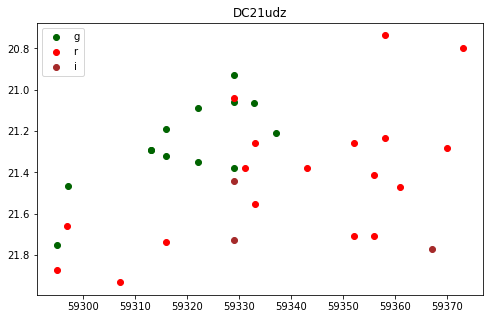

Reasons for failure:
g    No data
r     Passed
i     Passed
Name: DC21url, dtype: object


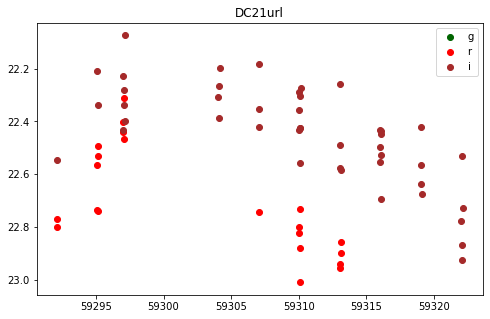

Reasons for failure:
g    Double-peaked
r          Too dim
i           Passed
Name: DC21vfz, dtype: object


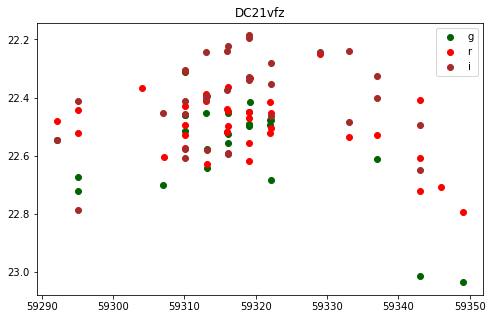

Reasons for failure:
g      Passed
r    <10 objs
i     No data
Name: DC21vnd, dtype: object


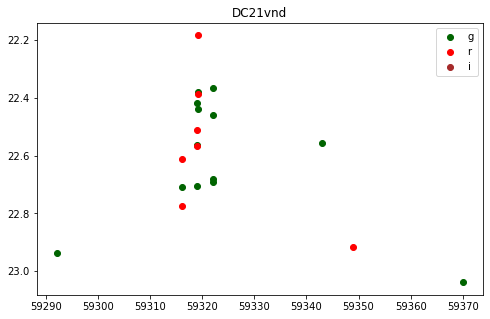

Reasons for failure:
g      Passed
r      Passed
i    <10 objs
Name: DC21wlm, dtype: object


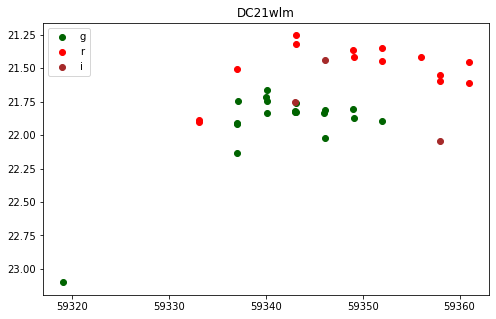

Reasons for failure:
g           Passed
r    Double-peaked
i          No data
Name: DC21wue, dtype: object


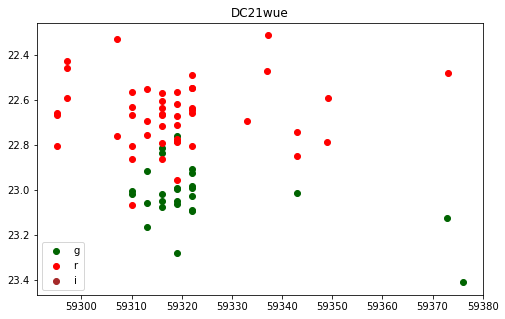

Reasons for failure:
g    Double-peaked
r         <10 objs
i           Passed
Name: DC21yn, dtype: object


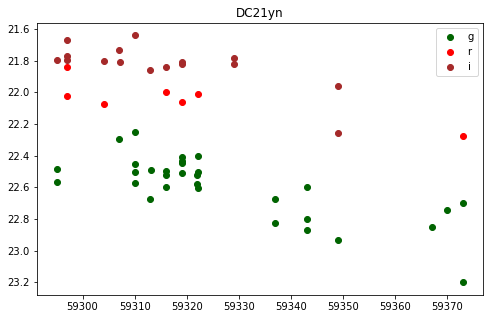

Reasons for failure:
g     Passed
r    No data
i    No data
Name: DC21zlo, dtype: object


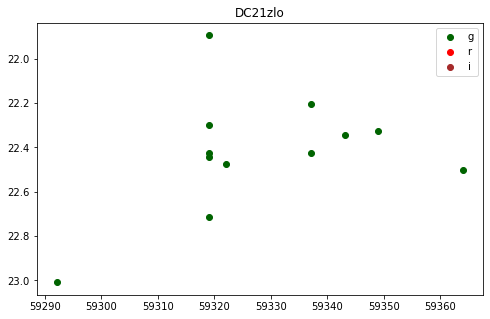

In [117]:
for i in onefiltcands:
    query = ('SELECT c.id, e.mjd, o.mag, e.filter FROM objects o '
             'JOIN candidates c ON c.id=o.candidate_id '
             'JOIN subtractions s ON s.id=o.subtraction_id '
             'JOIN exposures e ON e.id=s.exposure_id '
             'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
             'WHERE c.id=%s '
             'AND e.mjd < 59377 ' 
             'AND rbs.rb>0.6')
    cursor.execute( query, (i, ) )
    array = np.array(cursor.fetchall()).transpose()
    rmsk = np.where(array[3]=='r')[0]
    gmsk = np.where(array[3]=='g')[0]
    imsk = np.where(array[3]=='i')[0]
    
    plt.figure(figsize=(8,5))
    plt.scatter((array[1][gmsk]).astype(float), (array[2][gmsk]).astype(float), color=c[0], label='g')
    plt.scatter((array[1][rmsk]).astype(float), (array[2][rmsk]).astype(float), color=c[1], label='r')
    plt.scatter((array[1][imsk]).astype(float), (array[2][imsk]).astype(float), color=c[2], label='i')

    plt.title(array[0][0])
    plt.gca().invert_yaxis()
    plt.legend()
    print("Reasons for failure:")
    print(onefiltdf.loc[i])
    plt.show()

In [118]:
from IPython.display import clear_output

# def visinspect(SNlist):
#     SNvis = []
#     for i in SNlist:
#         query = ('SELECT c.id, e.mjd, o.mag, e.filter FROM objects o '
#                  'JOIN candidates c ON c.id=o.candidate_id '
#                  'JOIN subtractions s ON s.id=o.subtraction_id '
#                  'JOIN exposures e ON e.id=s.exposure_id '
#                  'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
#                  'WHERE c.id=%s '
#                  'AND rbs.rb>0.3')
#         cursor.execute( query, (i, ) )
#         array = np.array(cursor.fetchall()).transpose()
#         rmsk = np.where(array[3]=='r')[0]
#         gmsk = np.where(array[3]=='g')[0]
#         imsk = np.where(array[3]=='i')[0]

#         plt.figure(figsize=(8,5))
#         plt.scatter((array[1][gmsk]).astype(float), (array[2][gmsk]).astype(float), color=c[0], label='g')
#         plt.scatter((array[1][rmsk]).astype(float), (array[2][rmsk]).astype(float), color=c[1], label='r')
#         plt.scatter((array[1][imsk]).astype(float), (array[2][imsk]).astype(float), color=c[2], label='i')

#         plt.title(array[0][0])
#         plt.gca().invert_yaxis()
#         plt.legend()
#         plt.show()
#         yn = input("Does this pass visual muster? y/n")
#         if yn == 'y':
#             SNvis.append(i)
#         clear_output(wait=True)
#     return SNvis

def visinspect(SNlist):
    SNvis = []
    for i in SNlist:
        plotlc(i,cursor)
        yn = input("Does this pass visual muster? y/n")
        if yn == 'y':
            SNvis.append(i)
        clear_output(wait=True)
    return SNvis

In [119]:
# SNvis1 = visinspect(SNany)

In [120]:
SNvis = ['DC21bcpi', # those that passed my last visual inspection
 'DC21bkrj',
 'DC21bpls',
 'DC21bwbfe',
 'DC21chy',
 'DC21cove',
 'DC21dhgr',
 'DC21dna',
 'DC21dqf',
 'DC21dqik',
 'DC21dtwb',
 'DC21ebkp',
 'DC21edbu',
 'DC21eqq',
 'DC21eqtm',
 'DC21fber',
 'DC21fkyg',
 'DC21gayy',
 'DC21hunj',
 'DC21ikah',
 'DC21ixp',
 'DC21jfcb',
 'DC21jgl',
 'DC21kgy',
 'DC21kog',
 'DC21ktp',
 'DC21kxb',
 'DC21qil',
 'DC21qyq',
 'DC21url',
 'DC21vfz',
 'DC21wlm']

# Code to do another visual inspection:
# SNvis = visinspect(SNany)

In [121]:
query = ('SELECT o.mag FROM objects o '
         'JOIN candidates c ON c.id=o.candidate_id '
         'JOIN subtractions s ON s.id=o.subtraction_id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'JOIN objectrbs as rbs ON o.id=rbs.object_id AND rbs.rbtype_id=1 '
         'WHERE c.id=%s '
         'AND e.mjd < 59377 ' 
         'AND e.filter=%s '
         'AND rbs.rb>0.6')
ff = ['g', 'r', 'i']
SNpeak = np.zeros((len(SNvis),3))
for i in range(len(SNvis)):
    for j in [0,1,2]:
        cursor.execute(query, (SNvis[i],ff[j],))
        try:
            SNpeak[i][j] = np.max(np.array(cursor.fetchall()).transpose())
        except ValueError:
            pass

In [122]:
SNvisDF = pd.DataFrame(SNpeak, columns=ff,index=SNvis)

27


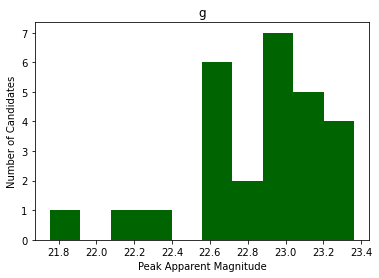

31


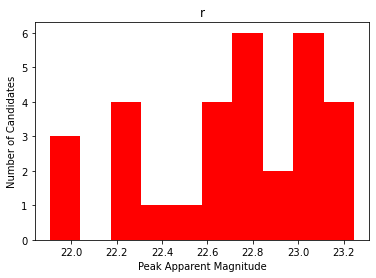

29


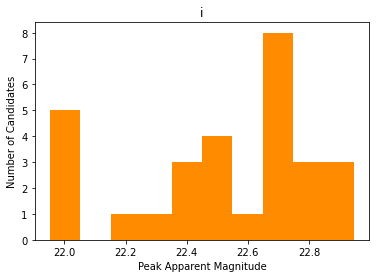

In [123]:
c = {"g": "darkgreen",
         "r": "red",
         "i": "darkorange"}
for i in ff:
    plt.title(i)
    plt.hist(SNvisDF[i][SNvisDF[i]>0], color=c[i])
    print(len(SNvisDF[i][SNvisDF[i]>0]))
    plt.xlabel("Peak Apparent Magnitude")
    plt.ylabel("Number of Candidates")
    plt.show()

In [124]:
# g,r : 22.5-23.2
# i : 22.3-22.
sum(((SNvisDF.loc[:,"i"]>22.3) & (SNvisDF.loc[:,"i"]<22.8)).astype(int))

19

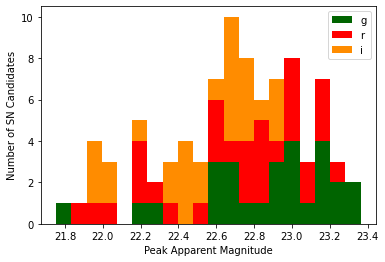

In [125]:
plt.hist([SNvisDF['g'][SNvisDF['g']>0],SNvisDF['r'][SNvisDF['r']>0],SNvisDF['i'][SNvisDF['i']>0]], color=['darkgreen','red','darkorange'], label=ff,stacked=True, bins=20)
plt.legend()
plt.xlabel("Peak Apparent Magnitude")
plt.ylabel("Number of SN Candidates")
plt.savefig("images/peakmaghist")
plt.show()